# Introduction
Voter Analysis exploration

## Imports
Import libraries and write settings here.

In [1]:
from fastai.tabular import *
from fastai import *

# Data manipulation
import pandas as pd
import numpy as np

# Options for pandas
pd.options.display.max_columns = 60
pd.options.display.max_rows = 60

# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

from IPython import get_ipython
ipython = get_ipython()

# autoreload extension
if 'autoreload' not in ipython.extension_manager.loaded:
    %load_ext autoreload

%autoreload 2

# Visualizations
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode
init_notebook_mode(connected=True)

import cufflinks as cf
cf.go_offline(connected=True)
cf.set_config_file(theme='white')

import seaborn as sns

#reproducability
np.random.seed(0)

# DETERMINE IF YOU ARE USING RAW OR SCALED
Scaled is Zhao's data, continuous variables divided by standard deviation
<br>Raw is unscaled raw data

In [2]:
useRaw=True

dropCorrelatedColumns=False  #dropping correlated columns?
dropSummaryColumns=False    #if above true, choose to drop summary columns or the columns that make them up

# Data Import and Cleaning

In [3]:
#get the data
if (useRaw == True):
    df = pd.read_csv('./data/ccesplus.csv',encoding = "ISO-8859-1")
else:
    df = pd.read_csv('./data/ccesplus_fscaled.csv',encoding = "ISO-8859-1")

In [4]:
#get rid of spaces and caps in column names (if any)
df.columns = [col.replace(' ','_').lower() for col in df.columns]

In [5]:
# df.head()
# df.columns
# df.describe()

#any duplicate rows?
df.duplicated().sum()

0

In [6]:
#lets see how many columns, how many have no and some missing values
print (f"Total columns={len(df.columns)}")
print(f"Total columns with no Nans= {len(df.columns[~df.isnull().any()])}") 
print(f"Total columns with Nans= {len(df.columns[df.isnull().any()])}") #add ~ to get columns with no missing values

Total columns=866
Total columns with no Nans= 268
Total columns with Nans= 598


The columns with no NaNs (missing values) are the easiest to use since we dont have to impute missing values

## Get a subset of the rows of the data to work on if desired

In [7]:
#get first thousand rows
# df=df[:1000]

## Get the columns of interest

In [8]:
all = pd.read_excel('./data/CCESplusVariables.xlsx',encoding = "ISO-8859-1")

# for every regid=3.1 get the third column (variable name) convert to a list
columns = list(all[all['regid']==3.1].iloc[:,2])

# #get the dependant variable(s)
# # columns_dep_var= ['cc.TrumpGEVote','cc.TrumpPVote', 'cc.vote12.gop']
columns_dep_var= 'cc.vote16'

# #combine
# columns.extend(columns_dep_var)

# #strip rubbish
columns = [col.replace(' ','_').lower() for col in columns]

## Create dataframe for model training

In [9]:
#select out the columns of interest
df_s=df[columns]

In [10]:
len(df_s.iloc[0])

56

### Output some info

In [11]:
# how many unique values there are per column, 
# use that to guide which columns are categorical and which are continuous
#pick largest value that looks continuous, for instance raceviewsum=17 
#(but see the docs many of theses fields are floats which meand fastai ignores cardinality)
for col in df_s.columns:
    print(f"{col}:{df[col].nunique()}")

cc.vote16:7
cc.emp.nojob:2
cc.cc16_304:5
cc.faminc:16
crashpc:2626
rustpc:2437
job.uer:761
econ.mhi:2646
econ.hhpov.p:1030
taa.wrks.disc95.pcpy:2120
cc.cc16_305_3:2
cc.cc16_305_2:2
cc.cc16_305_1:2
cc.cc16_305_7:2
cc.cc16_305_5:2
cc.cc16_305_11:2
cc.cc16_305_6:2
cc.cc16_305_9:2
cc.cc16_305_10:2
cc.cc16_305_4:2
cc.fortunesum:10
mort.ucd.despair.disc95.pdpy:2660
cc.cc16_331_2:2
cc.cc16_331_3:2
cc.cc16_331_7:2
cc.cc16_331_1:2
cc.immviewsum:5
cc.cc16_422c:5
cc.cc16_422d:5
cc.cc16_422e:5
cc.cc16_422f:5
cc.raceviewsum:17
cc.cc16_307:4
cc.cc16_351b:2
cc.age:80
cc.sex:2
cc.blackdum:2
cc.whitedum:2
cc.maxeduc.4yr:2
cc.citylength_1:94
cc.isimmigrant:2
cc.child18:2
cc.milstat_1:2
cc.milstat_3:2
cc.union:2
cc.cc16_300_5:2
cc.newsint:5
cc.ideo7:7
cc.evanprot:2
cc.catholic:2
cc.religiosity:15
eth.his.p:1019
relig.evan.pc:2665
demo.popdense:2668
cc.repdum:2
cc.inddum:2


In [12]:
#what types are the columns
df_s.dtypes

cc.vote16                       float64
cc.emp.nojob                      int64
cc.cc16_304                     float64
cc.faminc                       float64
crashpc                         float64
rustpc                          float64
job.uer                         float64
econ.mhi                        float64
econ.hhpov.p                    float64
taa.wrks.disc95.pcpy            float64
cc.cc16_305_3                     int64
cc.cc16_305_2                     int64
cc.cc16_305_1                     int64
cc.cc16_305_7                     int64
cc.cc16_305_5                     int64
cc.cc16_305_11                    int64
cc.cc16_305_6                     int64
cc.cc16_305_9                     int64
cc.cc16_305_10                    int64
cc.cc16_305_4                     int64
cc.fortunesum                   float64
mort.ucd.despair.disc95.pdpy    float64
cc.cc16_331_2                     int64
cc.cc16_331_3                     int64
cc.cc16_331_7                     int64


In [13]:
#the percentage of NaNs in each column, note the large percentage of missing values in the bottom columns
#I would guess that cc.faminc and cc.raceviewsum are critical
df_s.isna().sum().sort_values(ascending = True)/len(df)

cc.cc16_331_3                   0.000000
cc.cc16_305_4                   0.000000
cc.fortunesum                   0.000000
cc.milstat_1                    0.000000
cc.cc16_331_2                   0.000000
cc.cc16_331_7                   0.000000
cc.cc16_331_1                   0.000000
cc.cc16_305_10                  0.000000
cc.immviewsum                   0.000000
cc.age                          0.000000
cc.sex                          0.000000
cc.blackdum                     0.000000
cc.whitedum                     0.000000
cc.maxeduc.4yr                  0.000000
cc.isimmigrant                  0.000000
cc.cc16_300_5                   0.000000
cc.cc16_305_9                   0.000000
cc.milstat_3                    0.000000
cc.cc16_305_11                  0.000000
cc.cc16_305_5                   0.000000
cc.cc16_305_7                   0.000000
cc.cc16_305_1                   0.000000
cc.cc16_305_2                   0.000000
cc.cc16_305_3                   0.000000
cc.emp.nojob    

## Remove NaN dependent variable rows
whaddaya going to do?  You have no way of knowing how these people voted

In [14]:
print(f"There are {len(df_s)} rows in df_s")

There are 64600 rows in df_s


In [15]:
#dump the NaN rows
df_s = df_s[pd.notnull(df_s['cc.vote16'] )]
print(f"There are {len(df_s)} rows in df_s after removing rows with Nan for dependant variable")

There are 64320 rows in df_s after removing rows with Nan for dependant variable


## Convert cc.vote16 back to categorical

In [16]:
#how many unique values?
unique_vals = df_s['cc.vote16'].unique()
unique_vals

array([3., 1., 0., 2., 5., 4., 6.])

In [17]:
if (useRaw == True):
    mult=1.0
else:
    #cc.vote16 seems to have been scaled incorrectly, it should be categorical, convert it back
    #1/std_dev = .592302
    mult = 1/0.592302

#multiply col by mult to get close to original value
df_s['cc.vote16'] = (df_s['cc.vote16']*mult).astype('int64')

# unique_vals_unnormalized = unique_vals*std_dev
# unique_vals_unnormalized
# unique_vals_unnormalized = unique_vals_unnormalized.astype('int64')
# unique_vals_unnormalized

In [18]:
#causes nan for learner
# df_s['cc.trumpgevote'] = df_s['cc.trumpgevote'].astype('category');
# df_s['cc.trumpgevote'].cat.categories

In [19]:
#is the dataset balanced?
df_vc= df_s['cc.vote16'].value_counts()
df_vc
df_vc.sum()
df_vc[0]

2    22136
0    19389
1    18754
3     1829
6     1136
4      913
5      163
Name: cc.vote16, dtype: int64

64320

19389

In [20]:
#how about as percentages
print(f"total percentage of people who voted for trump in this dataset={100*df_vc[2]/df_vc.sum()}")
print(f"total percentage of people who voted for trump excluding non voters={100*df_vc[1]/(df_vc.sum()-df_vc[0])}")
print(f"total percentage of people who voted for Hillary excluding non voters={100*df_vc[2]/(df_vc.sum()-df_vc[0])}")

total percentage of people who voted for trump in this dataset=34.41542288557214
total percentage of people who voted for trump excluding non voters=41.73955620840845
total percentage of people who voted for Hillary excluding non voters=49.26665331285749


# Check on correlations


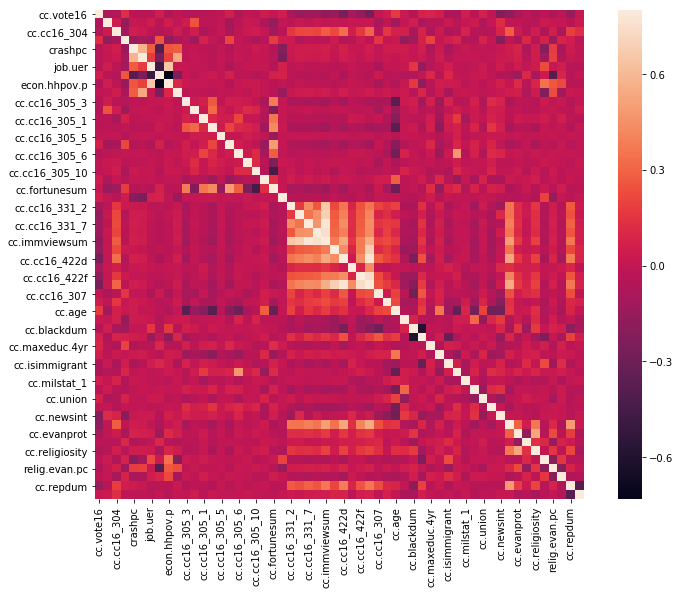

In [21]:
#correlation matrix
corrmat = df_s.corr(method='pearson')
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

#there is a lot of correlation here,the darks and the lights

In [22]:
#lets get top correlated columns
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=None):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    if (n is None):
        n=len(df.columns)
    return au_corr[0:n]

print("Top Absolute Correlations")
print(get_top_abs_correlations(df_s))


Top Absolute Correlations
cc.cc16_331_7   cc.immviewsum           0.780721
cc.cc16_422d    cc.raceviewsum          0.772481
cc.cc16_331_1   cc.immviewsum           0.754479
cc.cc16_422f    cc.raceviewsum          0.736505
econ.mhi        econ.hhpov.p            0.730862
cc.cc16_331_3   cc.immviewsum           0.684166
cc.cc16_422c    cc.raceviewsum          0.682102
job.uer         econ.hhpov.p            0.651577
cc.cc16_331_2   cc.immviewsum           0.651303
cc.blackdum     cc.whitedum             0.595172
crashpc         rustpc                  0.577588
cc.immviewsum   cc.raceviewsum          0.557516
cc.raceviewsum  cc.ideo7                0.547859
cc.immviewsum   cc.cc16_422d            0.541188
rustpc          taa.wrks.disc95.pcpy    0.532829
cc.cc16_422d    cc.ideo7                0.526753
cc.evanprot     cc.religiosity          0.526236
cc.immviewsum   cc.ideo7                0.500594
cc.cc16_305_11  cc.fortunesum           0.491183
cc.ideo7        cc.repdum               0.4

## Correlations above 50% are worrisome, especially when its a summary variable that adds up a bunch of other variables. Lets get rid of them

In [23]:
#dump columns that summaries are made of 
if (dropCorrelatedColumns ==True): #dropping correlated columns?
    if (dropSummaryColumns == True):
        summary_cols=[ 'cc.raceviewsum','cc.immviewsum']
    else:
        summary_cols=[ 'cc.cc16_331_7','cc.cc16_331_1', 'cc.cc16_331_3', 'cc.cc16_331_2', 'cc.cc16_422d','cc.cc16_422f','cc.cc16_422c','cc.cc16_422e']

    df_s.drop(summary_cols,axis=1,inplace=True)

## Split out categorical and continuous variables
see if fastai can auto do it

In [24]:
# #give fastai a shot at splitting cat and cont variables
res_cont, res_cat = cont_cat_split(df_s,max_card=18)

In [25]:
# ??cont_cat_split
print(res_cont)
print(res_cat)

['cc.cc16_304', 'cc.faminc', 'crashpc', 'rustpc', 'job.uer', 'econ.mhi', 'econ.hhpov.p', 'taa.wrks.disc95.pcpy', 'cc.fortunesum', 'mort.ucd.despair.disc95.pdpy', 'cc.immviewsum', 'cc.cc16_422c', 'cc.cc16_422d', 'cc.cc16_422e', 'cc.cc16_422f', 'cc.raceviewsum', 'cc.cc16_307', 'cc.cc16_351b', 'cc.age', 'cc.citylength_1', 'cc.child18', 'cc.union', 'cc.newsint', 'cc.ideo7', 'cc.evanprot', 'cc.catholic', 'cc.religiosity', 'eth.his.p', 'relig.evan.pc', 'demo.popdense', 'cc.repdum', 'cc.inddum']
['cc.vote16', 'cc.emp.nojob', 'cc.cc16_305_3', 'cc.cc16_305_2', 'cc.cc16_305_1', 'cc.cc16_305_7', 'cc.cc16_305_5', 'cc.cc16_305_11', 'cc.cc16_305_6', 'cc.cc16_305_9', 'cc.cc16_305_10', 'cc.cc16_305_4', 'cc.cc16_331_2', 'cc.cc16_331_3', 'cc.cc16_331_7', 'cc.cc16_331_1', 'cc.sex', 'cc.blackdum', 'cc.whitedum', 'cc.maxeduc.4yr', 'cc.isimmigrant', 'cc.milstat_1', 'cc.milstat_3', 'cc.cc16_300_5']


In [26]:
#remove the dependant variable
res_cont = [x for x in res_cont if x not in columns_dep_var]
res_cat = [x for x in res_cat if x not in columns_dep_var]

In [27]:
df_s.head()
len(df_s)

,cc.vote16,cc.emp.nojob,cc.cc16_304,cc.faminc,crashpc,rustpc,job.uer,econ.mhi,econ.hhpov.p,taa.wrks.disc95.pcpy,cc.cc16_305_3,cc.cc16_305_2,cc.cc16_305_1,cc.cc16_305_7,cc.cc16_305_5,cc.cc16_305_11,cc.cc16_305_6,cc.cc16_305_9,cc.cc16_305_10,cc.cc16_305_4,cc.fortunesum,mort.ucd.despair.disc95.pdpy,cc.cc16_331_2,cc.cc16_331_3,cc.cc16_331_7,cc.cc16_331_1,cc.immviewsum,cc.cc16_422c,cc.cc16_422d,cc.cc16_422e,cc.cc16_422f,cc.raceviewsum,cc.cc16_307,cc.cc16_351b,cc.age,cc.sex,cc.blackdum,cc.whitedum,cc.maxeduc.4yr,cc.citylength_1,cc.isimmigrant,cc.child18,cc.milstat_1,cc.milstat_3,cc.union,cc.cc16_300_5,cc.newsint,cc.ideo7,cc.evanprot,cc.catholic,cc.religiosity,eth.his.p,relig.evan.pc,demo.popdense,cc.repdum,cc.inddum
0,3,0,3.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0.0,NaN,0,0,0,1,0.25,1.0,2.0,2.0,2.0,1.75,4.0,0.0,57,1,0,1,0,NaN,0,0.0,2,2,0.0,1,2.0,6.0,0.0,0.0,16.0,NaN,NaN,NaN,1.0,0.0
1,1,0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,1,0,0,1,0,0.0,NaN,1,0,0,1,0.50,1.0,3.0,1.0,2.0,1.75,4.0,1.0,64,1,0,1,1,36.0,0,0.0,2,2,1.0,0,1.0,7.0,1.0,0.0,16.0,NaN,NaN,NaN,1.0,0.0
2,0,1,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0.0,NaN,0,1,0,1,0.50,NaN,NaN,NaN,NaN,NaN,3.0,1.0,24,0,0,0,0,7.0,0,0.0,2,2,0.0,0,2.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
3,0,0,3.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,0,0,0,1,1,0,0,-0.1,NaN,1,1,0,1,0.75,NaN,NaN,NaN,NaN,NaN,3.0,0.0,26,0,1,0,0,2.0,1,1.0,2,2,NaN,0,1.0,5.0,0.0,0.0,14.0,NaN,NaN,NaN,1.0,0.0
4,2,0,1.0,8.0,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1,0,0,0,0,0,0,0,0.1,NaN,0,0,0,0,0.00,1.0,1.0,1.0,1.0,1.00,4.0,0.0,75,0,0,1,1,15.0,0,0.0,2,2,0.0,0,1.0,1.0,0.0,0.0,11.0,NaN,NaN,NaN,0.0,0.0


64320

In [28]:
df_s.columns

Index(['cc.vote16', 'cc.emp.nojob', 'cc.cc16_304', 'cc.faminc', 'crashpc',
       'rustpc', 'job.uer', 'econ.mhi', 'econ.hhpov.p', 'taa.wrks.disc95.pcpy',
       'cc.cc16_305_3', 'cc.cc16_305_2', 'cc.cc16_305_1', 'cc.cc16_305_7',
       'cc.cc16_305_5', 'cc.cc16_305_11', 'cc.cc16_305_6', 'cc.cc16_305_9',
       'cc.cc16_305_10', 'cc.cc16_305_4', 'cc.fortunesum',
       'mort.ucd.despair.disc95.pdpy', 'cc.cc16_331_2', 'cc.cc16_331_3',
       'cc.cc16_331_7', 'cc.cc16_331_1', 'cc.immviewsum', 'cc.cc16_422c',
       'cc.cc16_422d', 'cc.cc16_422e', 'cc.cc16_422f', 'cc.raceviewsum',
       'cc.cc16_307', 'cc.cc16_351b', 'cc.age', 'cc.sex', 'cc.blackdum',
       'cc.whitedum', 'cc.maxeduc.4yr', 'cc.citylength_1', 'cc.isimmigrant',
       'cc.child18', 'cc.milstat_1', 'cc.milstat_3', 'cc.union',
       'cc.cc16_300_5', 'cc.newsint', 'cc.ideo7', 'cc.evanprot', 'cc.catholic',
       'cc.religiosity', 'eth.his.p', 'relig.evan.pc', 'demo.popdense',
       'cc.repdum', 'cc.inddum'],
      dtype='o

# Split out train/test sets for consistency
Neural Nets, Random Forest, etc will use same sets, so result differnces cannot be attributed to different splits

In [29]:
# split out train/test sets
from sklearn.model_selection import train_test_split

train,tst = train_test_split(df_s, test_size=0.1)
print(str(len(train)))
print(str(len(tst)))

57888
6432


#  Save train/test and catagorical and continuous column names

In [30]:
os.makedirs('tmp', exist_ok=True)

trnfile = 'tmp/trn_regid31'
tstfile = 'tmp/tst_regid31'
jsonfile = 'tmp/catcont_regid3.json'

if (useRaw == True):
    trnfile = 'tmp/trn_regid31_raw'
    tstfile = 'tmp/tst_regid31_raw'
    jsonfile = 'tmp/catcont_regid31_raw.json'
    
train.reset_index(inplace=True,drop=True)
train.to_feather(trnfile)

tst.reset_index(inplace=True,drop=True)
tst.to_feather(tstfile)

In [31]:
columns_dep_var
# columns_dep_var.split() #convert to a list

'cc.vote16'

In [32]:
import simplejson
with open(jsonfile,'w') as f:
    json.dump((res_cont,res_cat,columns_dep_var.split()), f)